# Advanced preprocessing with tiling

Note: The workflow in this notebook will be improved gradually as we go through the API update process.

The preprocessing routines in IFT prepare the images for segmentation by sharpening floe edges, enhancing contrast between ice and water, and by correcting for uneven illumination. 

In [1]:
# Root of the IFT folder
home_dir = "../.."
test_dir = joinpath(home_dir, "test")

using Pkg
# Specifying an environment makes it easier to work with package versions
Pkg.activate(joinpath(home_dir, "notebooks/ift-notebooks"))
using IceFloeTracker
using Images

  Activating project at `~/Documents/research/packages/IceFloeTracker.jl/notebooks/ift-notebooks`


# Available demonstration cases

Example files are included in `test/test_inputs/preprocessing_workflows/`.

Each example has truecolor, falsecolor, and landmask data for both Aqua and Terra. Image sizes are 50 km, 100 km, and 200 km.

In [2]:
# Available test cases. Only showing Aqua truecolor for brevity. Each case has Aqua, Terra and has truecolor, falsecolor, and landmasks.
example_loc = joinpath(test_dir, "test_inputs/preprocessing_workflows/")


# Filter out the csv files and similar
case_names = [f for f in readdir(example_loc) if occursin("km", f)]

9-element Vector{String}:
 "baffin_bay-200km-20060704"
 "barents_kara_seas-100km-20250507"
 "beaufort_sea-50km-20070614"
 "bering_chukchi_seas-200km-20210314"
 "east_siberian_sea-100km-20190612"
 "greenland_sea-50km-20180712"
 "hudson_bay-100km-20060513"
 "laptev_sea-200km-20230613"
 "sea_of_okhostk-50km-20180412"

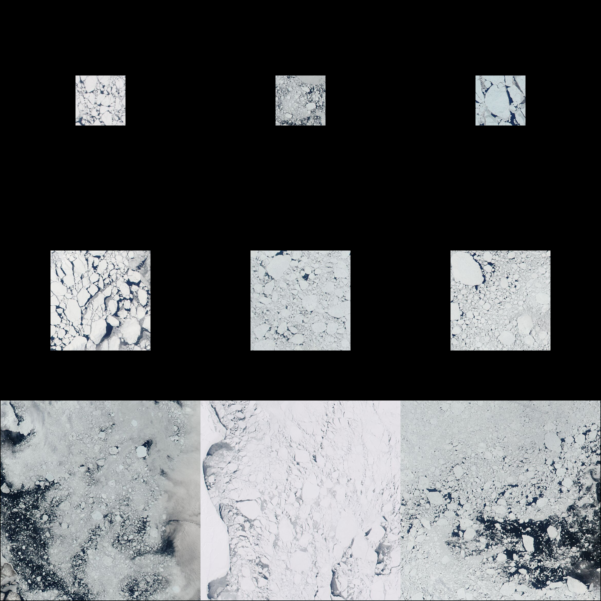

In [3]:
# Rearranged order just to make the figure prettier:
case_names = ["sea_of_okhostk-50km-20180412", "barents_kara_seas-100km-20250507",  "baffin_bay-200km-20060704", 
    "greenland_sea-50km-20180712", "east_siberian_sea-100km-20190612",  "bering_chukchi_seas-200km-20210314", 
    "beaufort_sea-50km-20070614", "hudson_bay-100km-20060513",  "laptev_sea-200km-20230613"]

file_names = [split(c, "-")[3]*".250m.aqua.truecolor.tiff" for c in case_names]

Images.mosaicview([RGB.(load(joinpath(example_loc, case, file)))
        for (case, file) in zip(case_names, file_names)], ncol=3)

For the rest of this demonstration, we'll pick a single image and work through each of the steps. First, we load the three image types for the chosen case.

Note: The current version is picky about image types, so we have to cast RGB and float64. Future versions will relax this requirement.
 

# Loading files

sea_of_okhostk-50km-20180412

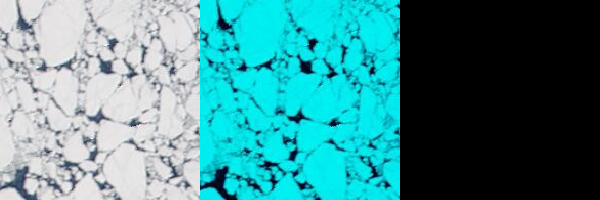

In [82]:
# case = "beaufort_sea-50km-20070614"
case = case_names[1]
print(case)
date = split(case, "-")[3]
satellite = "aqua"

lm_image = float64.(RGB.(load(joinpath(example_loc, case, join([date, "250m", satellite, "landmask.tiff"], ".")))))
fc_image = float64.(RGB.(load(joinpath(example_loc, case, join([date, "250m", satellite, "falsecolor.tiff"], ".")))))
tc_image = float64.(RGB.(load(joinpath(example_loc, case, join([date, "250m", satellite, "truecolor.tiff"], ".")))))

lm_image = float64.(RGB.(load( ))))
fc_image = float64.(RGB.(load( ))))
tc_image = float64.(RGB.(load( ))))


Images.mosaicview(tc_image, fc_image, lm_image, nrow=1)

# Masking
Next, we set up the cloud mask and land masks.

In [83]:
# First set up the cloudmask
cloud_mask_settings = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_upper=0.53
)

@time begin
    cloudmask = IceFloeTracker.create_cloudmask(fc_image; cloud_mask_settings...)
    fc_img_cloudmasked = IceFloeTracker.apply_cloudmask(fc_image, cloudmask)
end
nothing

  0.000804 seconds (51 allocations: 2.778 MiB)


In [84]:
# Then the landmask
# The landmask function takes an optional structuring element for a less agressive mask
@time begin
    landmask = IceFloeTracker.create_landmask(lm_image)
end
nothing

  0.001146 seconds (46 allocations: 369.391 KiB)


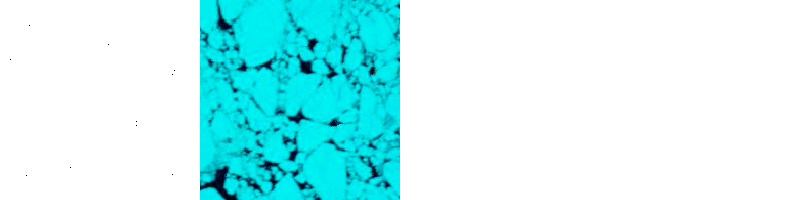

In [85]:
Images.mosaicview(Gray.(cloudmask), fc_img_cloudmasked, Gray.(landmask.non_dilated), Gray.(landmask.dilated), nrow=1)

From left to right: clouds marked white, cloudy regions in the falsecolor image masked and set to 0, the binarized land mask, and the dilated land mask.

Future warning: In the next update, we will default to clouds=1, non-cloud=0 as shown in the image.

# Tiling
The tiling functionality allows functions to be applied on sub-regions of the image. 
There are two layers of tiling that happen within the next step: one layer of user-specified tiles, then a second layer within the adaptive histogram equation that splits the image into 8 x 8 tiles.

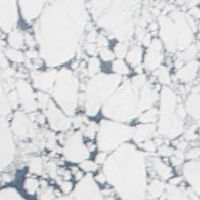

In [86]:
prelim_sizes = size(tc_image) .÷ 2

function build_tiling_illustration(img, side_length)

    # Create new canvas to draw on
    newimg = similar(img, RGBA{Float64})

    # Apply transparency to the tiles
    for tile_coords in IceFloeTracker.get_tiles(img, side_length)
        tile = @view img[tile_coords...]
        alpha = rand(0.5:0.05:1)
        transparent_tile = map(c -> RGBA(c.r, c.g, c.b, alpha), tile)
        newimg[tile_coords...] .= transparent_tile
    end

    # View the image
    newimg
end

newimg = build_tiling_illustration(tc_image, prelim_sizes[1] + 1);
Images.mosaicview(newimg)


# Conditional adaptive histogram equalization and diffusion
The `_process_image_tiles` function does
1. Anisotropic diffusion on each color channel
2. Conditional adaptive histogram

The adaptive histogram function only appears for tiles with a threshold of entropy and of white fraction.

In [87]:
# We'll go ahead with the tiles as defined above.
tiles = IceFloeTracker.get_tiles(tc_image, prelim_sizes[1] + 1);

# Get clouds_red for adaptive histogram equalization
fc_img_cloudmasked = IceFloeTracker.apply_cloudmask(fc_image, cloudmask)
clouds_red = IceFloeTracker.to_uint8(float64.(red.(fc_img_cloudmasked) .* 255))
clouds_red[.!landmask.dilated] .= 0;

# Set parameters
adapthisteq_params = (
    white_threshold=25.5, entropy_threshold=4, white_fraction_threshold=0.4
)


rgbchannels = IceFloeTracker._process_image_tiles(
    tc_image, clouds_red, tiles, adapthisteq_params...);

equalized_gray = IceFloeTracker.rgb2gray(rgbchannels);

Left: Grayscale original image, Middle: After process-image-tiles, Right: clouds-red object

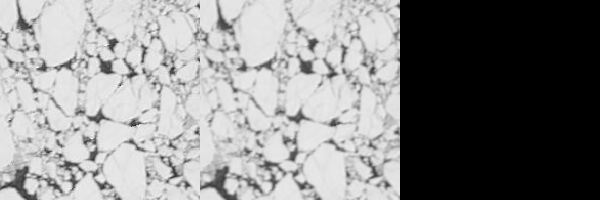

In [88]:
print("Left: Grayscale original image, Middle: After process-image-tiles, Right: clouds-red object")
Images.mosaicview(Gray.(tc_image), Gray.(equalized_gray/255), Gray.(clouds_red), nrow=1)

In [105]:
# Parameters used in preprocessing functions
adjust_gamma_params = (gamma=1.5, gamma_factor=1.3, gamma_threshold=220)

structuring_elements = (
    se_disk1=collect(IceFloeTracker.MorphSE.StructuringElements.strel_diamond((3, 3))),
    se_disk2=IceFloeTracker.se_disk2(),
    se_disk4=IceFloeTracker.se_disk4(),
)

unsharp_mask_params = (radius=10.0, amount=1.5, factor=255.0)

brighten_factor = 0.1;

TBD:
* Include the diffusion step as its own step in the preprocessing algorithm. Check its inputs and outputs, and allow the parameters to be adjusted. 
* Add the fc_image and cloud mask as an input, so that "clouds_red" is computed inside the function.
* Update so that it acts as a filter: image in, image out!
* Determine whether the entropy function needs to be scale dependent

In [106]:
IceFloeTracker.apply_cloudmask(Gray.(equalized_gray/255), cloudmask);

In [107]:
# question: how does this differ from a standard application of the cloud mask?
masks = [f.(fc_img_cloudmasked) .== 0 for f in [red, green, blue]]
combo_mask = reduce((a, b) -> a .& b, masks)
equalized_gray[.!cloudmask] .= 0;

Left to right: Equalized Gray, Sharpened Gray, Equalized Sharped Reconstructed Gray

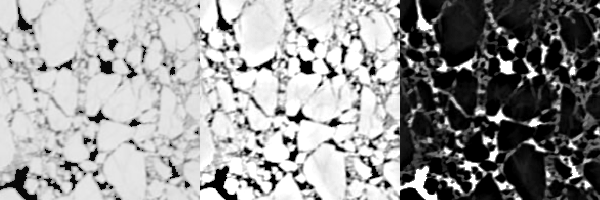

In [108]:
sharpened = IceFloeTracker.to_uint8(IceFloeTracker.unsharp_mask(equalized_gray, unsharp_mask_params...))
equalized_gray_sharpened_reconstructed = IceFloeTracker.reconstruct(
    sharpened, structuring_elements.se_disk1, "dilation", true
)
equalized_gray_sharpened_reconstructed[.!landmask.dilated] .= 0;
print("Left to right: Equalized Gray, Sharpened Gray, Equalized Sharped Reconstructed Gray")
Images.mosaicview([Gray.(equalized_gray./255),
        Gray.(sharpened./255), Gray.(equalized_gray_sharpened_reconstructed./255)], nrow=1)

From left to right: The result of the conditional histogram equalization, application of sharpening, sharpening, reconstruction, and landmask application.

Something is likely incorrect here since the landmask has the wrong sign.

In [114]:
# step 6
equalized_gray_reconstructed = deepcopy(equalized_gray)
equalized_gray_reconstructed[.!landmask.dilated] .= 0
equalized_gray_reconstructed = IceFloeTracker.reconstruct(
    equalized_gray_reconstructed, structuring_elements.se_disk4, "dilation", true
)
equalized_gray_reconstructed[.!landmask.dilated] .= 0;

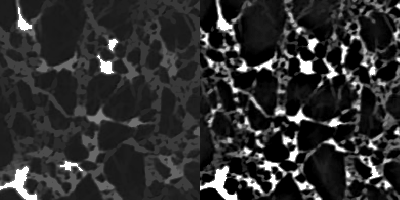

In [115]:
Images.mosaicview([Gray.(equalized_gray_reconstructed./255), Gray.(equalized_gray_sharpened_reconstructed./255)], nrow=1)

Left: Equalized Gray Reconstructed, Right: Equalized Gray Brightened

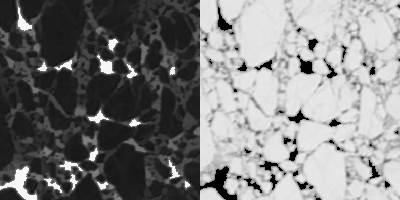

In [111]:
# step 7
gammagreen = @view rgbchannels[:, :, 2];
brighten = IceFloeTracker.get_brighten_mask(equalized_gray_reconstructed, gammagreen)
equalized_gray[.!landmask.dilated] .= 0
equalized_gray .= IceFloeTracker.imbrighten(equalized_gray, brighten, brighten_factor)
print("Left: Equalized Gray Reconstructed, Right: Equalized Gray Brightened")
Images.mosaicview([Gray.(equalized_gray_reconstructed./255), Gray.(equalized_gray./255)], nrow=1)

In [112]:
# step 8
morphed_residue = clamp.(equalized_gray - equalized_gray_reconstructed, 0, 255)

equalized_gray_sharpened_reconstructed_adjusted = IceFloeTracker.imcomplement(
    IceFloeTracker.adjustgamma(equalized_gray_sharpened_reconstructed, adjust_gamma_params.gamma))
adjusting_mask = equalized_gray_sharpened_reconstructed_adjusted .> adjust_gamma_params.gamma_threshold
morphed_residue[adjusting_mask] .= IceFloeTracker.to_uint8.(morphed_residue[adjusting_mask] .* adjust_gamma_params.gamma_factor);

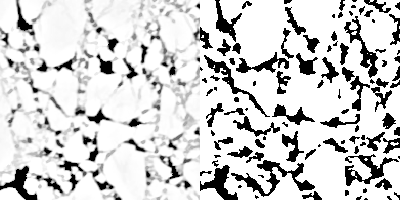

In [119]:
Images.mosaicview(Gray.(equalized_gray_sharpened_reconstructed_adjusted/255),
Gray.(adjusting_mask), nrow=1)

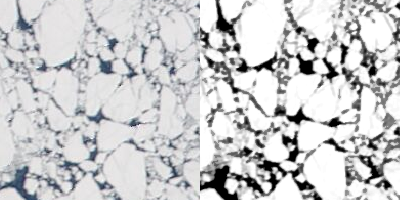

In [113]:
Images.mosaicview(tc_image, Gray.(morphed_residue./255), nrow=1)

In [98]:
Images.save(joinpath(example_loc, case, join([date, "250m", satellite, "morphed_residue.tiff"], ".")),
     Gray.(morphed_residue./255))
Images.save(joinpath(example_loc, case, join([date, "250m", satellite, "cloudmask.tiff"], ".")),
    Gray.(cloudmask))